# Wind Farm Power Prediction

In [1]:
# load modules (install floris)
from floris.floris import Floris
import numpy as np
import matplotlib.pyplot as plt
import scipy
import gpflow
import GPy
import random
from pygmo import hypervolume

# Visualization
from copy import deepcopy
from visualization_manager import VisualizationManager
from pareto import Pareto
from scipy.optimize import minimize
from scipy.stats import norm
from pareto import Pareto
%matplotlib inline

# Define Wind Farm Power Calculator
## inputs are:
floris object (that will be initiated with wind farm configuations, i.e., number of WT, locations)

wd (wind direction)

ws (wind speed)

yawAngle (action vector whose dimension is the number of wind turbines) 

In [2]:
def windFarmPower(floris,wd, ws, yawAngle,scale):
    
    #set up wind direction and speed
    floris.farm.flow_field.wind_direction = np.radians(wd - 270) # frame of reference is west
    floris.farm.flow_field.wind_speed = ws
    floris.farm.flow_field.initial_flowfield = floris.farm.flow_field._initial_flowfield()
    floris.farm.flow_field.u_field = floris.farm.flow_field._initial_flowfield()
    
    
    turbines    = [turbine for _, turbine in floris.farm.flow_field.turbine_map.items()]
    for k,turbine in enumerate(turbines):
        turbine.yaw_angle = np.radians(yawAngle[k])
    floris.farm.flow_field.calculate_wake()
    
    power = np.zeros([len(yawAngle),1])
    totalPower = 0.0
    for i, turbine in enumerate(turbines):
        power[i]=turbine.power
        totalPower = totalPower + turbine.power    
    
    return power/scale, totalPower/scale/len(turbines)

# Compute the maximum wind turbine power using single wind turbine 

In [3]:
#run wind farm configuration input with a single wind turbine
floris = Floris("example_input_single.json")
numWT = 1
scale = 1.0
#conventional default input is yawAngle = 0 degree
yawAngle0 = np.zeros(numWT)

#compute the wind turbine power vector and total wind farm power (for single wind turbine they are the same)
powerSingle,totalPower = windFarmPower(floris,0, 8, yawAngle0,scale)

for coord, turbine in floris.farm.turbine_map.items():
    print(str(coord) + ":")
    print("\tCp -", turbine.Cp)
    print("\tCt -", turbine.Ct)
    print("\tpower -", turbine.power)
    print("\tai -", turbine.aI)
    print("\taverage velocity -", turbine.get_average_velocity())

(0.0, 0.0):
	Cp - 0.46328782548262326
	Ct - 0.7661304442831962
	power - 1712005.1679717556
	ai - 0.2581996920407235
	average velocity - 7.85065163365446


## Setup Wind Farm Layout
### Open "example_input_double.json" and look at how the wind farm is defined

In [4]:
floris = Floris("example_input_9.json")

# Compute the power vector and total wind farm power

In [5]:
wd=180;
ws=8;
num_tur = len(floris.farm.flow_field.turbine_map.items())
yawAngle = np.ones(num_tur)*0.01
power, totalPower = windFarmPower(floris, wd, 8, yawAngle, powerSingle)
totalPower

array([[0.50672764]])

# Compare the greedy control and cooperative control (optimized yaw angle vector)

In [6]:
def hypervolume_poi(Xcand, gp_models, pareto, reference, outdim, wind_dir):
    Xcand = np.atleast_2d(Xcand)
    Xcand = np.hstack((Xcand, np.ones((len(Xcand), 1)) * wind_dir))
    num_cells = pareto.bounds.lb.shape[0]
    N = Xcand.shape[0]

    # Extended Pareto front
    pf_ext = np.concatenate([-np.inf * np.ones([1, outdim], dtype=float), pareto.front, reference], 0)

    # Predictions for candidates, concatenate columns
    preds = [m.predict(Xcand) for m in gp_models]
    candidate_mean, candidate_var = (np.concatenate(moment, 1) for moment in zip(*preds))
    candidate_var = np.maximum(candidate_var, 1e-6)  # avoid zeros

    # Calculate the cdf's for all candidates for every predictive distribution in the data points
    normal = scipy.stats.norm(candidate_mean, np.sqrt(candidate_var))
    Phi = np.transpose(normal.cdf(np.expand_dims(pf_ext, 1)), [1, 0, 2])  # N x pf_ext_size x outdim
    # tf.gather_nd indices for bound points
    col_idx = np.tile(range(outdim), (num_cells,))
    ub_idx = np.stack((np.reshape(pareto.bounds.ub, [-1]), col_idx), axis=1).astype(int)  # (num_cells*outdim x 2)
    lb_idx = np.stack((np.reshape(pareto.bounds.lb, [-1]), col_idx), axis=1).astype(int)  # (num_cells*outdim x 2)
    
    # Calculate PoI
    P1 = np.zeros((N, num_cells*outdim))
    P2 = np.zeros((N, num_cells*outdim))
    for i in range(len(ub_idx)):
        for k in range(N):
            P1[k,i] = np.transpose(Phi, [1, 2, 0])[ub_idx[i][0],ub_idx[i][1], k]  # N x num_cell*outdim
            P2[k,i] = np.transpose(Phi, [1, 2, 0])[lb_idx[i][0],lb_idx[i][1], k]  # N x num_cell*outdim
    P = np.reshape(P1 - P2, [N, num_cells, outdim])
    PoI = np.sum(np.prod(P, axis=2), axis=1, keepdims=True)  # N x 1

    # Calculate Hypervolume contribution of points Y
    ub_points = np.zeros((1, num_cells*outdim))
    lb_points = np.zeros((1, num_cells*outdim))
    for i in range(len(ub_idx)):
        ub_points[0,i] = pf_ext[ub_idx[i][0],ub_idx[i][1]]
        lb_points[0,i] = pf_ext[lb_idx[i][0],lb_idx[i][1]]
    ub_points = np.reshape(ub_points, [num_cells, outdim])
    lb_points = np.reshape(lb_points, [num_cells, outdim])

    splus_valid = np.all(np.tile(np.expand_dims(ub_points, 1), [1, N, 1]) > candidate_mean,
                                axis=2)  # num_cells x N
    splus_idx = np.expand_dims(splus_valid.astype(np.float64), -1)  # num_cells x N x 1
    splus_lb = np.tile(np.expand_dims(lb_points, 1), [1, N, 1])  # num_cells x N x outdim
    splus_lb = np.maximum(splus_lb, candidate_mean)  # num_cells x N x outdim
    splus_ub = np.tile(np.expand_dims(ub_points, 1), [1, N, 1])  # num_cells x N x outdim
    splus = np.concatenate([splus_idx, splus_ub - splus_lb], axis=2)  # num_cells x N x (outdim+1)
    Hv = np.transpose(np.sum(np.prod(splus, axis=2), axis=0, keepdims=True))  # N x 1
    
    # return HvPoI
    return -np.multiply(Hv, PoI)

In [7]:
def sample_next_point(acquisition, gp_model, bounds, pareto, reference, outdim, wind_dir, N_mc = 5000):
    """
    acquisition : acquisition function of Gaussian processes
    gp_model : gpflow Gaussian process model
    eval_y : evaluated y list in current state
    bounds : boundary of next point
    n_restarts : number of restarts for scipy.minimize
    
    return : next x    
    """
    best_x = None
    best_acquisition_value = 0
    n_params = bounds.shape[0]
    points = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(N_mc, n_params))
    evaluations = acquisition(points, gp_model, pareto, reference, outdim, wind_dir)
    idx_best = np.argmin(evaluations, axis=0)
    
    result = minimize(fun=acquisition, x0=points[idx_best, :], bounds=bounds, method='L-BFGS-B',args=(gp_model, pareto, reference, outdim, wind_dir))
    if result.fun <= best_acquisition_value:
        best_acquisition_value = result.fun
        best_x = result.x

    return best_x

In [8]:
def multiobj_f(yawangle):
    Y1 = np.zeros(len(yawangle))[:,None]
    Y2 = np.zeros(len(yawangle))[:,None]
    for i,angle in enumerate(yawangle):
        power,totalPower = windFarmPower(floris, angle[-1], 8, angle[:-1], powerSingle)
        Y1[i] = -totalPower
        Y2[i] = np.sum(np.square(np.radians(angle[:-1]))) / np.square(np.radians(25.0)) / num_tur
    Y = np.hstack((Y1,Y2))
    return Y

In [9]:
minimum_yaw_angle = 0.0
maximum_yaw_angle = 25.0

bounds = np.zeros((num_tur, 2))
for i in range(num_tur):
    bounds[i,:] = [minimum_yaw_angle, maximum_yaw_angle]
    
# number of turbines + wind context
n_params = bounds.shape[0]+1

In [10]:
co = np.arange(0, 45, 0.1)
ang = np.zeros(num_tur)
po = []
for i in co:
    pow1, totalp = windFarmPower(floris, i, 8, ang, powerSingle)
    po.append(totalp)
po = np.array(po).reshape((len(po), 1))

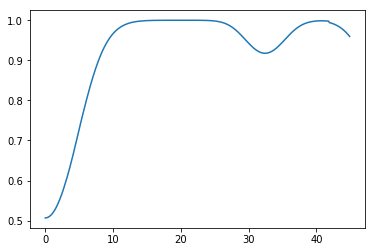

In [11]:
plt.plot(co, po)
plt.show()

In [12]:
# test_c = np.random.uniform(0, 45)
test_c = 0

In [25]:
# initial data point of wind-farm
init_sample = 1
wd_init = np.random.uniform(0, 45, size=(init_sample, 1))
    
X = np.zeros((init_sample, bounds.shape[0]))
for i, yawangles in enumerate(np.random.uniform(bounds[:, 0], bounds[:, 1], (init_sample, bounds.shape[0]))):
    X[i,:] = yawangles
X = np.hstack((X, wd_init))
Y = multiobj_f(X)

In [26]:
num_output = Y.shape[1]
num_iter = 300
wd_context = np.random.uniform(0, 45, size=(num_iter, 1))

for i in range(num_iter):
    if i % 5 == 0:
        wd_context[i] = test_c


for i in range(num_iter):
    pareto = Pareto(np.empty((0, num_output)))
    reference = np.ones((1, num_output))
    
    gp_models = [GPy.models.GPRegression(X.copy(), Y[:,[i]].copy(), kernel= GPy.kern.Matern52(input_dim=n_params, ARD=True)) for i in range(Y.shape[1])]
    for m in gp_models:
        m.optimize()
    
    trusted_X = np.array([X[j] for j in range(len(X)) if wd_context[i]-50 <= X[j,-1] <= wd_context[i]+50])
    context_X = np.hstack((trusted_X[:,:-1], np.ones((len(trusted_X), 1)) * wd_context[i]))    
    preds =  [m.predict(context_X) for m in gp_models]
    context_Y, var = (np.concatenate(moment, 1) for moment in zip(*preds))
    pareto.update(context_Y)
    pf = pareto.front
    f = np.max(pf, axis=0, keepdims=True) - np.min(pf, axis=0, keepdims=True)
    reference = np.max(pf, axis=0, keepdims=True) + 2 * f / pf.shape[0]
        
    next_point = np.atleast_2d(sample_next_point(hypervolume_poi, gp_models, bounds, pareto, reference, num_output, wd_context[i]))
    next_point = np.hstack((next_point, np.ones((1,1)) * wd_context[i]))
    X = np.append(X, next_point, axis = 0)
    function_value = multiobj_f(np.atleast_2d(next_point))
    Y = np.append(Y, function_value, axis = 0)

 /home/cwj/venv/local/lib/python3.5/site-packages/floris/wake_velocity.py:226: RuntimeWarning:invalid value encountered in sqrt
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:244: RuntimeWarning:invalid value encountered in true_divide
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:551: RuntimeWarning:invalid value encountered in multiply
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:554: RuntimeWarning:invalid value encountered in subtract
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary

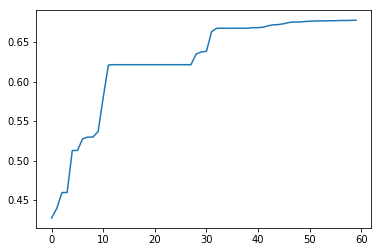

In [27]:
target_index = [i for i in range(len(X)) if X[i][-1] == test_c]
volume = []
ref_point = [0,1]
for i in range(len(Y[target_index])):
    hv = hypervolume(Y[target_index][:i+1])
    v = hv.compute(ref_point)
    volume.append(v)
plt.plot(volume)
plt.show()

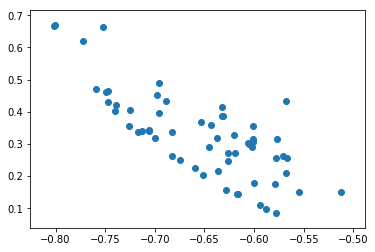

In [28]:
plt.scatter(Y[target_index][:,0], Y[target_index][:,1])
plt.show()

In [21]:
# initial data point of wind-farm
init_sample = 1
context_number = 30
context_list = np.random.uniform(0, 45, size=(context_number, 1))

wd_init = np.random.choice(context_list.flatten(), init_sample)[:,None]

X = np.zeros((init_sample, bounds.shape[0]))
for i, yawangles in enumerate(np.random.uniform(bounds[:, 0], bounds[:, 1], (init_sample, bounds.shape[0]))):
    X[i,:] = yawangles
X = np.hstack((X, wd_init))
Y = multiobj_f(X)

In [22]:
num_output = Y.shape[1]
num_iter = 300
wd_context = np.random.uniform(0, 45, size=(num_iter, 1))

for i in range(num_iter):
    if i % 5 == 0:
        wd_context[i] = test_c

for i in range(num_iter):
    pareto = Pareto(np.empty((0, num_output)))
    reference = np.ones((1, num_output))
    
    gp_models = [GPy.models.GPRegression(X.copy(), Y[:,[i]].copy(), kernel= GPy.kern.Matern52(input_dim=n_params, ARD=True)) for i in range(Y.shape[1])]
    for m in gp_models:
        m.optimize()
    
    trusted_X = np.array([X[j] for j in range(len(X)) if wd_context[i]-50 <= X[j,-1] <= wd_context[i]+50])
    context_X = np.hstack((trusted_X[:,:-1], np.ones((len(trusted_X), 1)) * wd_context[i]))    
    preds =  [m.predict(context_X) for m in gp_models]
    context_Y, var = (np.concatenate(moment, 1) for moment in zip(*preds))
    pareto.update(context_Y)
    pf = pareto.front
    f = np.max(pf, axis=0, keepdims=True) - np.min(pf, axis=0, keepdims=True)
    reference = np.max(pf, axis=0, keepdims=True) + 2 * f / pf.shape[0]
       
    next_point = np.atleast_2d(sample_next_point(hypervolume_poi, gp_models, bounds, pareto, reference, num_output, wd_context[i]))
    next_point = np.hstack((next_point, np.ones((1,1)) * wd_context[i]))
    X = np.append(X, next_point, axis = 0)
    function_value = multiobj_f(np.atleast_2d(next_point))
    Y = np.append(Y, function_value, axis = 0)

 /home/cwj/venv/local/lib/python3.5/site-packages/floris/wake_velocity.py:226: RuntimeWarning:invalid value encountered in sqrt
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:551: RuntimeWarning:invalid value encountered in multiply
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:554: RuntimeWarning:invalid value encountered in subtract
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:244: RuntimeWarning:invalid value encountered in true_divide
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary

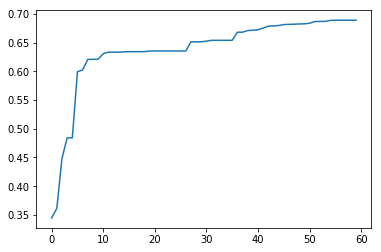

In [23]:
target_index = [i for i in range(len(X)) if X[i][-1] == test_c]
volume = []
ref_point = [0,1]
for i in range(len(Y[target_index])):
    hv = hypervolume(Y[target_index][:i+1])
    v = hv.compute(ref_point)
    volume.append(v)
plt.plot(volume)
plt.show()

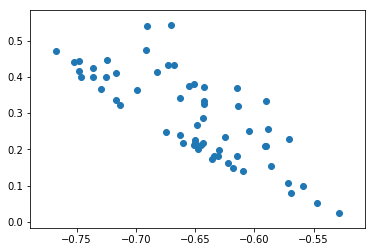

In [67]:
plt.scatter(Y[target_index][:,0], Y[target_index][:,1])
plt.show()

In [30]:
# Generate context
def generate_context(lower, upper, length):
    con = [0]
    for i in range(length-1):
        prob = np.random.uniform(0,1)
        if prob >= 0.5:
            if con[-1] + 1 > upper:
                new_c = con[-1] - 1
            else:
                new_c = con[-1] + 1      
        else:
            if con[-1] - 1 < lower:
                new_c = con[-1] + 1      
            else:
                new_c = con[-1] - 1
        con.append(new_c)
    return np.array(con)[:,None]

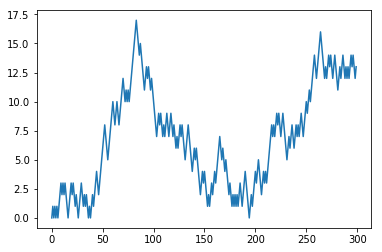

In [32]:
plt.plot(generate_context(0, 45, 300))
plt.show()

In [33]:
# initial data point of wind-farm
init_sample = 1
upper = 45
lower = 0
wd_init = generate_context(lower, upper, init_sample)

X = np.zeros((init_sample, bounds.shape[0]))
for i, yawangles in enumerate(np.random.uniform(bounds[:, 0], bounds[:, 1], (init_sample, bounds.shape[0]))):
    X[i,:] = yawangles
X = np.hstack((X, wd_init))
Y = multiobj_f(X)

In [34]:
num_output = Y.shape[1]
num_iter = 300
wd_context = generate_context(lower, upper, num_iter)

for i in range(num_iter):
    if i % 5 == 0:
        wd_context[i] = test_c

for i in range(num_iter):
    pareto = Pareto(np.empty((0, num_output)))
    reference = np.ones((1, num_output))
    
    gp_models = [GPy.models.GPRegression(X.copy(), Y[:,[i]].copy(), kernel= GPy.kern.Matern52(input_dim=n_params, ARD=True)) for i in range(Y.shape[1])]
    for m in gp_models:
        m.optimize()
    
    trusted_X = np.array([X[j] for j in range(len(X)) if wd_context[i]-20 <= X[j,-1] <= wd_context[i]+20])
    context_X = np.hstack((trusted_X[:,:-1], np.ones((len(trusted_X), 1)) * wd_context[i]))    
    preds =  [m.predict(context_X) for m in gp_models]
    context_Y, var = (np.concatenate(moment, 1) for moment in zip(*preds))
    pareto.update(context_Y)
    pf = pareto.front
    f = np.max(pf, axis=0, keepdims=True) - np.min(pf, axis=0, keepdims=True)
    reference = np.max(pf, axis=0, keepdims=True) + 2 * f / pf.shape[0]
    

    next_point = np.atleast_2d(sample_next_point(hypervolume_poi, gp_models, bounds, pareto, reference, num_output, wd_context[i]))
    next_point = np.hstack((next_point, np.ones((1,1)) * wd_context[i]))
    X = np.append(X, next_point, axis = 0)
    function_value = multiobj_f(np.atleast_2d(next_point))
    Y = np.append(Y, function_value, axis = 0)

 /home/cwj/venv/local/lib/python3.5/site-packages/floris/wake_velocity.py:226: RuntimeWarning:invalid value encountered in sqrt
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:244: RuntimeWarning:invalid value encountered in true_divide
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:551: RuntimeWarning:invalid value encountered in multiply
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:554: RuntimeWarning:invalid value encountered in subtract
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary

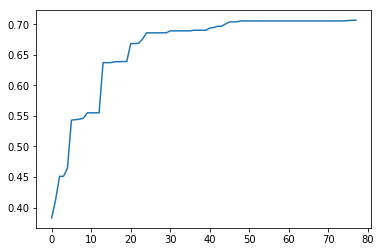

In [35]:
target_index = [i for i in range(len(X)) if X[i][-1] == test_c]
volume = []
ref_point = [0,1]
for i in range(len(Y[target_index])):
    hv = hypervolume(Y[target_index][:i+1])
    v = hv.compute(ref_point)
    volume.append(v)
plt.plot(volume)
plt.show()

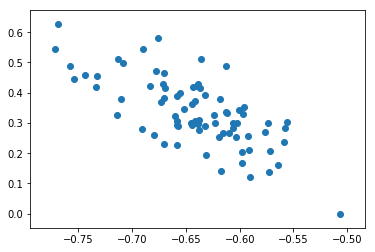

In [36]:
plt.scatter(Y[target_index][:,0], Y[target_index][:,1])
plt.show()

In [37]:
volume

[0.38310176308440513,
 0.4128934647892797,
 0.4511184808278677,
 0.4511184808278678,
 0.4647546726042734,
 0.5431107498269703,
 0.5438283373594822,
 0.5446073450292157,
 0.5460772821321969,
 0.5550282250347753,
 0.5550282250347753,
 0.5550282250347753,
 0.5550282250347753,
 0.6371407572301622,
 0.6371407572301622,
 0.6371407572301622,
 0.6385949648546603,
 0.6385949648546603,
 0.6389925410473134,
 0.6389925410473134,
 0.6683473015725264,
 0.6683473015725264,
 0.6688381514630337,
 0.6758416366402163,
 0.6858971920702706,
 0.6858971920702706,
 0.6858971920702706,
 0.6858971920702706,
 0.6859885770094207,
 0.6859885770094207,
 0.6891930187282975,
 0.6891930187282975,
 0.6891930187282975,
 0.6891930187282975,
 0.6891930187282975,
 0.6891930187282977,
 0.690184417654921,
 0.690184417654921,
 0.690184417654921,
 0.6901844176549212,
 0.6936196839484972,
 0.694813258336382,
 0.6966129686530298,
 0.6968493902775862,
 0.7005212098792816,
 0.7037694909173122,
 0.7037694909173122,
 0.7042375551473

In [45]:
np.min(Y[target_index], axis = 0)

array([-0.77187694,  0.        ])

In [42]:
import OptModules  # modules used for optimizing FLORIS
import numpy as np
import imp

imp.reload(OptModules)
optangle1 = OptModules.wake_steering(floris,minimum_yaw_angle,maximum_yaw_angle)
windFarmPower(floris, 0, 8, np.degrees(optangle1), powerSingle)

Optimizing wake redirection control...
Number of parameters to optimize =  9


(array([[0.85738744],
        [0.83114795],
        [0.83114795],
        [0.71560728],
        [0.85738744],
        [0.71560728],
        [0.83114795],
        [0.85738744],
        [0.71560728]]), array([[0.80138089]]))